# Deep Convolutional GAN (DCGAN)

This is a very simple extension of what we had seen before in our [Intro to GANS](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/Generative%20Adversarial%20Network/Intro%20to%20GANs/Intro%20to%20Gans.ipynb)! Except this time, we will use a full Convolutional Generator and Discriminator. Here I will be training on the CelebA Faces dataset, but on Colab you will see the same method applied to MNIST. 

### Implementation Details

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/dcgan_implementation.png?raw=true" alt="drawing" width="600"/>

For our input, we will pass in noise. Just like before, we decide the latent dimension of the noise, but one exception is, we add in a dummy dimension, to make the noise seem like it has latent_dim channels, and has a 1 x 1 resolution. We then use Convolutions of Kernel size 4 to upsample this repeatedly until we get to our target resolution (B x 3 x 64 x 64). All details of the Generator Convolutions are found in the image above!

DCGAN had a few implementation details from the paper that we want to follow!

- Due to the unstable nature of GANs, the found that adding BatchNorm to every layer (except the last layer of the Generator and the first layer of the discriminator) greatly improves training effectiveness.
- In the Discriminator, using LeakyReLU activation rather than ReLU allows for some negative gradients to flow in for incorrectly classified images (especially for higher resolution models)
- In the Generator, using ReLU worked the best for generated image quality
- There are no Fully Connected layers anymore, it is a fully Convolutional Model!
- They found better results when initializing all the weights of the convolutions and batchnorms from a gaussian normal distribution



In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Define The Model

In [2]:
class Generator(nn.Module):
    def __init__(self, 
                 out_channels=3,
                 in_channels_latent_dim=100):
        super().__init__()

        self.out_channels = out_channels
        self.latent_dim = in_channels_latent_dim
        
        self.generator = nn.Sequential(

            ### (B x 100 x 1 x 1) -> (B x 1024 x 4 x 4) ###
            nn.ConvTranspose2d(self.latent_dim, 1024, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            ### (B x 1024 x 4 x 4) -> (B x 512 x 8 x 8)###
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            ### (B x 512 x 8 x 8) -> (B x 256 x 16 x 16) ###
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.ReLU(),

            ### (B x 256 x 16 x 16) -> (B x 128 x 32 x 32) ###
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            ### (B x 128 x 32 x 32) -> (B x 3 x 64 x 64) ###
            nn.ConvTranspose2d(128, self.out_channels, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )

        self.apply(_init_weights)
        
    def forward(self, x):
        return self.generator(x)

class Discriminator(nn.Module):
    def __init__(self,
                 in_channels=3):
        super().__init__()

        self.discriminator = nn.Sequential(

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0),
        )

        self.apply(_init_weights)

    def forward(self, x):
        batch_size = x.shape[0]
        return self.discriminator(x).reshape(batch_size,1)         

def _init_weights(module):
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(module.weight, 0.0, 0.02)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)



### Training Parameters

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img_size = 64
batch_size = 64
img_channels = 3
latent_dimension = 100
training_epochs = 10
learning_rate = 1e-4
num_workers = 16

### Image Transformations

In [4]:
transforms = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        ),
    ]
)

dataset = ImageFolder("../../../data/CelebA/", transform=transforms)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=num_workers, 
                        pin_memory=True)

### Define Models ###

In [5]:
generator = Generator(out_channels=img_channels, 
                      in_channels_latent_dim=latent_dimension).to(device)
discriminator = Discriminator(in_channels=img_channels).to(device)

### Define Adam Optimizer

We will be using the Adam optimizer, as the paper found better results with a Momentum-based optimizer. But, something we haven't had to mess with is the ```beta1``` and ```beta2``` parameters of Adam. To compute momentum, we need to keep a history of previous gradients to see how fast and in what direction the gradients are moving. The $\beta_1$ parameter controls the exponential decay of the first moment (moving average) of the gradients, and then the $\beta_2$ parameter controls the exponential decay of the second moment (moving average of squared gradients).
 
#### Beta 1
By default, $\beta_1$ is set to 0.9. Larger values will put more emphasis (less decay) on historical gradient values, whereas reducing it will put less emphasis. Typically, the reason to lower $\beta_1$ is to make our optimizer more quickly responsive to sudden changes in the gradient. In our case, we will be reducing our $\beta_1$ parameter to 0.5, so our discriminator can quickly adapt to the generator and vice-versa. 

#### Beta 2
By default $\beta_2$ is set to 0.999, and because its an estimate of the history of squared gradients, it effectively gives information about the variance of graidents and how large they have been. By using a larger $\beta_2$, if we have a large spike in gradient in our current step, we can help smooth it out by the previous square gradients. Again, if we reduce our $\beta_2$ parameter, it makes our optimizer less sensitive to the history and more responsive to sudden changes. We will leave this parameter alone, although we want our generator and discriminator to be reactive to each other, we also need smoother gradients for stable learning, and leaving a high $\beta_2$ parameter should help with that 

In [6]:
gen_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

loss_fn = nn.BCEWithLogitsLoss()

### Training Script

This training script is almost identical to that found in our [Intro to GANS](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/Generative%20Adversarial%20Network/Intro%20to%20GANs/Intro%20to%20Gans.ipynb) so you can find more details there!

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 0/50 | Generator Loss: 1.7974065368640897 | Discriminator Loss: 0.4701511908089595


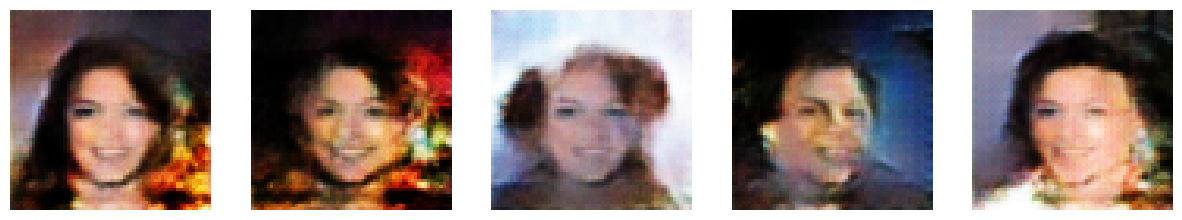

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 10/50 | Generator Loss: 1.9514365381857148 | Discriminator Loss: 0.3633305892414182


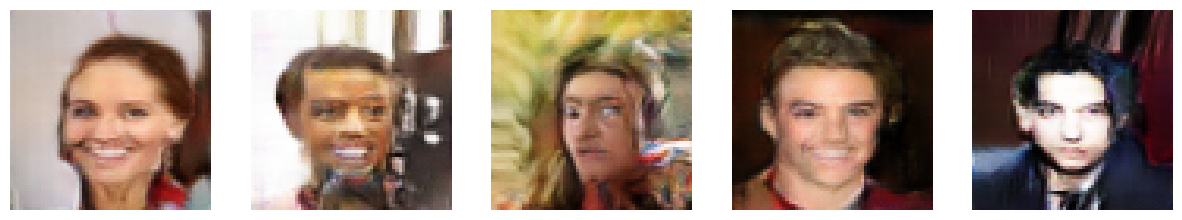

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 20/50 | Generator Loss: 2.3443438473262894 | Discriminator Loss: 0.30411577290624137


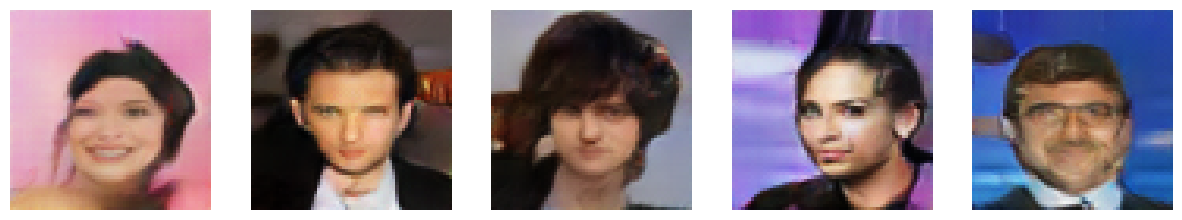

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 30/50 | Generator Loss: 2.5161231700907534 | Discriminator Loss: 0.2844744934003261


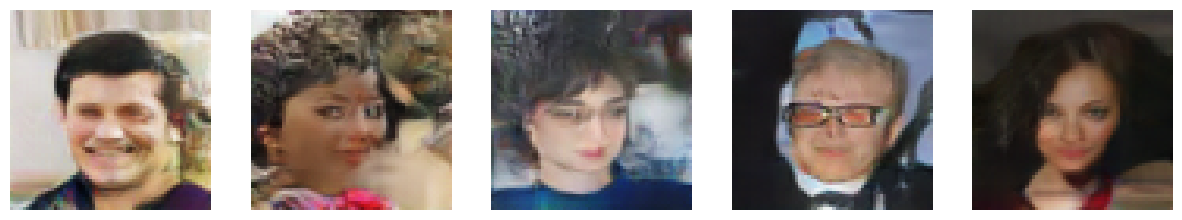

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 40/50 | Generator Loss: 2.6092743722137137 | Discriminator Loss: 0.27017227955637896


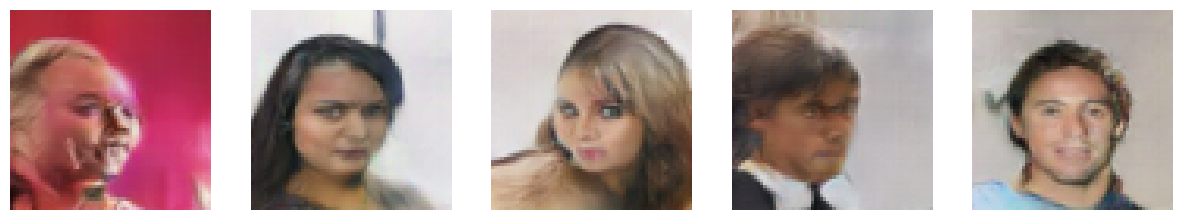

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

In [7]:
def train_unconditional_gan(generator, 
                            discriminator, 
                            generator_optimizer, 
                            discriminator_optimizer, 
                            dataloader,
                            label_smoothing=0.05,
                            epochs=200,
                            device="cpu", 
                            plot_generation_freq=50,
                            plot_loss_freq=20):

    ### Define Loss Function (Will do Sigmoid Internally) ###
    loss_func = nn.BCEWithLogitsLoss()

    gen_losses, disc_losses = [], []
    
    for epoch in tqdm(range(epochs)):
    
        generator_epoch_losses = []
        discriminator_epoch_losses = []
        
        for images, _ in tqdm(dataloader, leave=False):
    
            batch_size = images.shape[0]
    
            ### These are our real images!! ###
            images = images.to(device)
            
            ########################################################## 
            ################ TRAIN DISCRIMINATOR #####################
            ########################################################## 
            
            ### Sample noise for Generation ###
            noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)

            ### Create Labels for Discriminator with label smoothing ###
            generated_labels = torch.zeros(batch_size, 1, device=device) + label_smoothing
            true_labels = torch.ones(batch_size, 1, device=device) - label_smoothing
    
            ### Generate Samples G(z) and Take Off Computational Graph ###
            generated_images = generator(noise).detach()

            ### Pass Generated and Real Images into Discriminator ###
            real_discriminator_pred = discriminator(images) 
            gen_discriminator_pred = discriminator(generated_images)

            ### Compute Discriminator Loss ###
            real_loss = loss_func(real_discriminator_pred, true_labels)
            fake_loss = loss_func(gen_discriminator_pred, generated_labels)
            discriminator_loss = (real_loss + fake_loss) / 2
            discriminator_epoch_losses.append(discriminator_loss.item())

            ### Update Discriminator ###
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            ########################################################## 
            ################## TRAIN GENERATOR #######################
            ########################################################## 
            
            ### Sample noise for Generation ###
            noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)

            ### Generate Images ###
            generated_images = generator(noise)

            ### Pass Into Discriminator (to fool) ###
            gen_discriminator_pred = discriminator(generated_images)

            ### Compute Generator Loss ###
            generator_loss = loss_func(gen_discriminator_pred, true_labels)
            generator_epoch_losses.append(generator_loss.item())

            ### Update the Generator ###
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
            
        generator_epoch_losses = np.mean(generator_epoch_losses)
        discriminator_epoch_losses = np.mean(discriminator_epoch_losses)
    
        if epoch % plot_loss_freq == 0:
            print(f"Epoch: {epoch}/{epochs} | Generator Loss: {generator_epoch_losses} | Discriminator Loss: {discriminator_epoch_losses}")
    
        gen_losses.append(generator_epoch_losses)
        disc_losses.append(discriminator_epoch_losses)
    
        if epoch % plot_generation_freq == 0:
            generator.eval()
            with torch.no_grad():
                noise_sample = torch.randn(5, latent_dimension, 1, 1, device=device)
                generated_imgs = generator(noise_sample).to("cpu")
        
                fig, ax = plt.subplots(1,5, figsize=(15,5))
        
                for i in range(5):
                    img = (generated_imgs[i].squeeze() + 1)/2

                    if len(img.shape) == 3:
                        img = img.permute(1,2,0)
                        
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()
        
                plt.show()
                
            generator.train()

    return generator, discriminator, gen_losses, disc_losses

generator, discriminator, gen_losses, disc_losses = train_unconditional_gan(generator, 
                                                                            discriminator, 
                                                                            gen_optimizer, 
                                                                            disc_optimizer, 
                                                                            dataloader,
                                                                            label_smoothing=0.05,
                                                                            epochs=50,
                                                                            device=device, 
                                                                            plot_generation_freq=10,
                                                                            plot_loss_freq=10)